# Sentiment Analysis on Disneyland Resort Reviews

In this example, we will extract valuable sentiments from Disneyland Resort reviews, gaining a deeper understanding of customer experiences. 

We will leverage the power of Natural Language Processing (NLP) and sentiment analysis techniques to assess the sentiment expressed in these reviews. But that's not all, our approach doesn't stop at sentiment analysis; it extends to the realm of powerful vector databases.

Using KDB.AI we can store not only the reviews themselves but also the sentiment labels as metadata. With KDB.AI, we can easily search for any topic, keyword, or sentiment and retrieve relevant customer reviews instantly. Whether you're interested in finding the happiest moments in the park, uncovering areas for improvement, or simply exploring the multitude of experiences Disneyland Resort has to offer, KDB.AI makes it all possible with just a few clicks.

## Aim 

In the sections that follow, we'll walk you through the entire process:

- Data Loading: We'll load reviews and prepare them for analysis.
- Sentiment Analysis: Using advanced NLP techniques, we'll determine the sentiment expressed in each review—positive, negative, or neutral.
- KDB.AI Integration: We'll introduce you to KDB.AI and demonstrate how to store reviews and their associated sentiment labels.
- Flexible Searching: Learn how to use KDB.AI's powerful search capabilities to explore reviews based on your criteria.
- Visualization: We'll create visualizations to gain insights from the sentiment data.

By the end of this tutorial, you'll not only have a deeper understanding of sentiment analysis but also the tools and knowledge to harness the insights hidden within vast datasets of customer reviews. Let's embark on this journey to uncover the magic and meaning behind Disneyland Resort reviews with sentiment analysis and KDB.AI.


## Install Dependencies & Load Libraries

In [ ]:
%pip install seaborn kdbai_client -q

In [47]:
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Data Loading 

### Dataset overview
The dataset that will be used for this example is these [Disneyland Reviews](https://www.kaggle.com/datasets/arushchillar/disneyland-reviews) available on Kaggle. The dataset includes 42,000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor.

### Download data

You can either manually download the zip folder from [Kaggle (39MB)](https://www.kaggle.com/datasets/arushchillar/disneyland-reviews) or alternatively you can use the [Kaggle API](https://www.kaggle.com/docs/api). You will need to install the kaggle package and get an API token to do the latter approach.

Adjust the path if needed to match your setup.

In [3]:
# Read in data
df = pd.read_csv('./DisneylandReviews.csv',encoding='ISO-8859-1')
df.head(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


### Filtering

Let's take a look at the number of reviews per resort.

In [4]:
df.groupby('Branch')['Branch'].count()

Branch
Disneyland_California    19406
Disneyland_HongKong       9620
Disneyland_Paris         13630
Name: Branch, dtype: int64

We have a good number per resort so let's take the first 50 per resort only to help with performance.

The speed of your hardware, particularly your CPU and memory, will influence processing time when running sentiment analysis. If you are running this example on a CPU it is a good idea to restrict the number of rows first to help with performance. If you have access to a GPU you may wish to use that and the full dataset.

In [5]:
df = df.groupby('Branch').head(50)
df.groupby('Branch')['Branch'].count()

Branch
Disneyland_California    50
Disneyland_HongKong      50
Disneyland_Paris         50
Name: Branch, dtype: int64

## 2. Sentiment Analysis

Sentiment analysis, the process of determining the emotional tone or sentiment expressed in text, has seen significant advancements with the use of transformer-based models. In this section, we explore sentiment analysis using the powerful [Hugging Face Transformers](https://huggingface.co/docs/transformers/model_doc/roberta) library.

### Import tokenizer and model

We begin by importing essential components, including the sentiment analysis model and tokenizer. In this example, we use the RoBERTa model, which is fine-tuned for sentiment classification tasks. The model is capable of classifying text into three sentiment labels: positive, negative, and neutral.

Key Components:

- **AutoModelForSequenceClassification**: This component is a pre-trained transformer model fine-tuned for sequence classification tasks like sentiment analysis. It's designed to handle various NLP tasks, making it highly versatile.
- **AutoTokenizer**: We use the tokenizer to preprocess and encode text data before feeding it to the model.
- **MODEL**: This variable specifies the pre-trained sentiment analysis model we're using in this example.

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [7]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(MODEL,num_labels=3)

### Sentiment pipeline configuration

In this section, we configure the sentiment analysis pipeline using the Hugging Face Transformers library. 

This configuration enables us to easily perform sentiment analysis on text data by utilizing the pre-trained model within the pipeline. The 'sentiment' function streamlines the process of obtaining sentiment labels and scores, making it convenient for analyzing reviews or textual data and interpreting the sentiment expressed within them.

In [8]:
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=sentiment_model,
    tokenizer=tokenizer,
    )

def sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = sentiment_pipeline(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments][0]
    s = [x["score"] for x in sentiments][0]
    return l, s

labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

### Get sentiment for one review

In [9]:
example = df['Review_Text'][10]
print(example)
sentiment(example)

Disneyland never cease to amaze me! I've been to Disneyland florida and I thought I have exhausted the kid in me but nope! I still had so much fun in disneyland hong kong. 2 DL off my bucketlist and more to come!     


('positive', 0.9825873970985413)

We can see that the Roberta Model has identified this as a very positive score which makes sense when reading the text.

Great - now let's run our pipeline on the entire dataset.

### Get sentiment for entire DataFrame

In this code snippet, we perform sentiment analysis on the entire DataFrame containing reviews. 

The process involves iterating through each row of the DataFrame, extracting text data, and using a sentiment analysis function `sentiment` to analyze the sentiment of each review. Additionally, it includes error handling to gracefully handle any issues that may arise during the sentiment analysis process.

This code will take a few minutes to run - you can always reduce or increase the size of the input data depending on your machines performance.

In [10]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review_Text']
        myid = row['Review_ID']
        roberta_result = sentiment(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/150 [00:00<?, ?it/s]

Broke for id 668777351
Broke for id 669706763
Broke for id 667308717


We can see it broke for some IDs which is okay - these may have been too long for the RoBERTa model and have been ignored.

Let's merge the sentiment analysis results obtained from the sentiment analysis process with the original DataFrame.

In [11]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Review_ID',0: 'Label',1:'Score'})
results_df = results_df.merge(df, how='left')
results_df

,Review_ID,Label,Score,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,positive,0.984786,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,positive,0.858987,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,positive,0.898818,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,positive,0.863198,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,positive,0.56407,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...,...,...
142,667573212,neutral,0.379349,3,2019-4,United Kingdom,I visited Disneyland Paris with my 2 nieces an...,Disneyland_Paris
143,667557905,negative,0.450606,3,2019-4,United States,"Don't get my wrong, my family have been to Dis...",Disneyland_Paris
144,667525007,positive,0.543937,5,2019-4,United Kingdom,First time to Disneyland Paris. Really enjoyed...,Disneyland_Paris
145,667458156,positive,0.834823,4,2019-1,United Kingdom,We went to Disneyland in JanuraryWasnt as magi...,Disneyland_Paris


Visualizing this, we can see the variety in sentiment across the 3 resorts and compare the the rating the customer gave in their review. For the positive reviews we see all 4* or 5* reviews which makes sense. The negative reviews have lower ratings with the California resort getting the lowest ratings off all resorts.

<Axes: xlabel='Label', ylabel='Rating'>

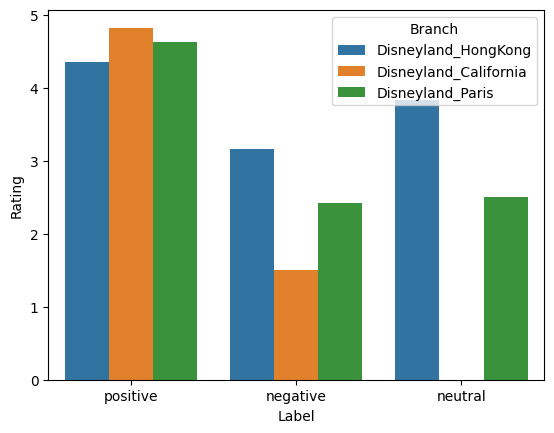

In [12]:
sns.barplot(data=results_df, x='Label', y='Rating', hue='Branch', errorbar=None)

 This consolidated dataset can be further analyzed, visualized, and in this example we will add it to our KDB.AI vector database to gain insights into the sentiments expressed in the reviews.

## 3. Generate Embeddings

Before adding to KDB.AI, we utilize the [Sentence Transformers](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) library to perform text embedding. Text embedding is the process of converting textual data into numerical vectors that capture semantic meaning.

The `embeddings` DataFrame provides a combined view of the original data we want to store as metadata in KDB.AI and the associated embeddings.

In [13]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def encode_text(text):
    return embedding_model.encode(text)

results_df['embeddings'] = results_df['Review_Text'].apply(encode_text)
embeddings = results_df[["Branch","Label","Score","Rating","Review_Text","embeddings"]]
embeddings

,Branch,Label,Score,Rating,Review_Text,embeddings
0,Disneyland_HongKong,positive,0.984786,4,If you've ever been to Disneyland anywhere you...,"[0.12519377, -0.047441833, 0.08718413, 0.01021..."
1,Disneyland_HongKong,positive,0.858987,4,Its been a while since d last time we visit HK...,"[0.047256127, -0.022195388, 0.12704654, -0.017..."
2,Disneyland_HongKong,positive,0.898818,4,Thanks God it wasn t too hot or too humid wh...,"[0.102995664, 0.01865532, 0.1257222, 0.0850504..."
3,Disneyland_HongKong,positive,0.863198,4,HK Disneyland is a great compact park. Unfortu...,"[0.14166501, -0.016745638, 0.086689875, 0.0085..."
4,Disneyland_HongKong,positive,0.56407,4,"the location is not in the city, took around 1...","[0.113461755, 0.0044915043, 0.0656381, 0.05553..."
...,...,...,...,...,...,...
142,Disneyland_Paris,neutral,0.379349,3,I visited Disneyland Paris with my 2 nieces an...,"[0.108627796, -0.015511898, 0.080564946, -0.02..."
143,Disneyland_Paris,negative,0.450606,3,"Don't get my wrong, my family have been to Dis...","[0.08578645, -0.045992117, 0.11141084, -0.0063..."
144,Disneyland_Paris,positive,0.543937,5,First time to Disneyland Paris. Really enjoyed...,"[0.12477912, -0.040522363, 0.092204586, -0.066..."
145,Disneyland_Paris,positive,0.834823,4,We went to Disneyland in JanuraryWasnt as magi...,"[0.10855069, 0.030211926, 0.08613848, 0.043550..."


## 4. Store Embeddings in KDB.AI

With the embeddings created, we need to store them in a vector database to enable efficient searching. KDB.AI is perfect for this task.

### Connect to KDB.AI session

To use KDB.AI, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI session using `kdbai.Session`. Enter the session URL endpoint and API key details from your KDB.AI Cloud portal below.

In [ ]:
import kdbai_client as kdbai
from getpass import getpass

KDBAI_ENDPOINT = input('KDB.AI endpoint: ')
KDBAI_API_KEY = getpass('KDB.AI API key: ')
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Define schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings.

At this point you will select the index and metric you want to use for searching.

In [39]:
review_schema = {
    "columns": [
        {"name": "Branch", "pytype": "str"},
        {"name": "Label", "pytype": "str"},
        {"name": "Score", "pytype": "float64"},
        {"name": "Rating", "pytype": "int64"},
        {"name": "Review_Text", "pytype": "str"},
        {
            "name": "embeddings",
            "vectorIndex": {"dims": 384, "metric": "CS", "type": "hnsw"},
        },
    ]
}

### Create and save table

Use `create_table` to create table.

In [49]:
table = session.create_table("review", review_schema)

We can use `query` to see our table exists but is empty.

In [52]:
table.query()

,Branch,Label,Score,Rating,Review_Text,embeddings


### Add embeddings to index

In [53]:
table.insert(embeddings)

True

Rerunning `query` we can now see the embeddings and metadata have been added.

In [54]:
table.query()

,Branch,Label,Score,Rating,Review_Text,embeddings
0,Disneyland_HongKong,positive,0.984786,4,If you've ever been to Disneyland anywhere you...,"[0.12519377, -0.047441833, 0.08718413, 0.01021..."
1,Disneyland_HongKong,positive,0.858987,4,Its been a while since d last time we visit HK...,"[0.047256127, -0.022195388, 0.12704654, -0.017..."
2,Disneyland_HongKong,positive,0.898818,4,Thanks God it wasn t too hot or too humid wh...,"[0.102995664, 0.01865532, 0.1257222, 0.0850504..."
3,Disneyland_HongKong,positive,0.863198,4,HK Disneyland is a great compact park. Unfortu...,"[0.14166501, -0.016745638, 0.086689875, 0.0085..."
4,Disneyland_HongKong,positive,0.564070,4,"the location is not in the city, took around 1...","[0.113461755, 0.0044915043, 0.0656381, 0.05553..."
...,...,...,...,...,...,...
142,Disneyland_Paris,neutral,0.379349,3,I visited Disneyland Paris with my 2 nieces an...,"[0.108627796, -0.015511898, 0.080564946, -0.02..."
143,Disneyland_Paris,negative,0.450606,3,"Don't get my wrong, my family have been to Dis...","[0.08578645, -0.045992117, 0.11141084, -0.0063..."
144,Disneyland_Paris,positive,0.543937,5,First time to Disneyland Paris. Really enjoyed...,"[0.12477912, -0.040522363, 0.092204586, -0.066..."
145,Disneyland_Paris,positive,0.834823,4,We went to Disneyland in JanuraryWasnt as magi...,"[0.10855069, 0.030211926, 0.08613848, 0.043550..."


## 5. Flexible Searching

Next, let's create a function to let us perform a search, retrieve relevant results, and return them in a DataFrame format, allowing for further analysis or examination of the retrieved data.

In [47]:
def search_and_extract_results(search_term, n):
    # Encode the search term
    search_term_embedded = [embedding_model.encode(search_term).tolist()]

    # Perform the search
    results = table.search(search_term_embedded, n=n)

    # Extract the results to a DataFrame
    if results:
        results_df = results[0].drop('embeddings', axis=1)
        return results_df
    else:
        return None  # Return None if no results are found

Let's try with a query, calling with the search term "are customers satisfied with the food at the park?" and requesting 10 results. 

In [51]:
search_and_extract_results("are customers satisfied with the food at the park?",10)

,Branch,Label,Score,Rating,Review_Text,__nn_distance
0,Disneyland_Paris,negative,0.914860,2,Visited the Park today 20 4 and can conclu...,0.600825
1,Disneyland_California,positive,0.763060,5,I wish they had better food restaurant choices...,0.568034
2,Disneyland_California,positive,0.962652,5,We found this park to provide family friendly ...,0.492384
3,Disneyland_Paris,negative,0.450606,3,"Don't get my wrong, my family have been to Dis...",0.483248
4,Disneyland_HongKong,positive,0.985430,3,The park is great if this is the only amusemen...,0.477172
5,Disneyland_Paris,positive,0.905848,5,I just Love Disneyland ParkBeen there several ...,0.464798
6,Disneyland_Paris,negative,0.646106,2,I know Disneyland is a money machine but hadn ...,0.448986
7,Disneyland_Paris,negative,0.861247,1,Its a shame this park carry the name Disney......,0.447803
8,Disneyland_Paris,positive,0.882301,5,First time at Disneyland Paris and had the mos...,0.445165
9,Disneyland_California,positive,0.376557,3,Took my son to the Park on a weekend(Fri Sun)....,0.438407


### Group results by resort

This functions provides a convenient way to perform sentiment analysis on reviews or data associated with different branches or contexts, aggregating sentiment counts for each branch based on a given search term. 

It enables insights into the sentiments expressed in reviews within specific contexts, which can be valuable for analyzing customer feedback and making data-driven decisions.

In [57]:
def sentiment_counts_by_resort(search_term, n):
    result = search_and_extract_results(search_term, n)
    def sentiment_counts(result):
        # Store count of sentiment labels
        sentiments = {
            "negative": 0,
            "neutral": 0,
            "positive": 0,
        }
        # Iterate through search results
        for index, row in result.iterrows():
            # Extract the sentiment label and increase its count
            label = row["Label"]
            sentiments[label] += 1
        return sentiments

    grouped_df = result.groupby("Branch").apply(sentiment_counts).reset_index()
    grouped_df.columns = ["Branch", "Sentiments"]
    return grouped_df

In [58]:
sentiment_counts_by_resort("are customers satisfied with the food at the park?",25)

,Branch,Sentiments
0,Disneyland_California,"{'negative': 2, 'neutral': 0, 'positive': 8}"
1,Disneyland_HongKong,"{'negative': 1, 'neutral': 0, 'positive': 5}"
2,Disneyland_Paris,"{'negative': 4, 'neutral': 0, 'positive': 5}"


### Visualization function

To further improve the interpretability of the results let's define some functions for visualization.

In [93]:
def plot_sentiment(search_term, n):
    df = sentiment_counts_by_park(search_term,n)
    dfs_per_branch = []

    # Iterate through the branches and create separate DataFrames
    for index, row in df.iterrows():
        branch_name = row["Branch"]
        sentiment_counts = row["Sentiments"]

        # Create a DataFrame from the sentiment_counts dictionary
        sentiment_df = pd.DataFrame([sentiment_counts])

        # Add a "Branch" column to identify the branch
        sentiment_df["Branch"] = branch_name

        dfs_per_branch.append(sentiment_df)

    # Concatenate all DataFrames into one
    final_df = pd.concat(dfs_per_branch, ignore_index=True)

    # Melt the DataFrame for easier plotting
    final_df = final_df.melt(id_vars=["Branch"], var_name="Sentiment", value_name="Count")

    # Create a bar plot with different colors per Branch and a legend
    plt.figure(figsize=(10, 4))
    sns.barplot(x="Sentiment", y="Count", hue="Branch", data=final_df)
    plt.title(search_term)
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.legend(title="Park", loc="upper right")
    plt.show()

pd.set_option('display.max_colwidth', 200)

### Guest satisfaction with rides and attractions

Top 3 matches: 0    We didn't realise it was school holidays when we went, so consequently it was extremely busy with ride wait times of up to 95 minutes or more, which was disappointing. We only went on 2 rides (Ind...
1              We had a terrific time at Disneyland HongKong   rides were fun, waiting times ok, shows were enjoyable, very clean, staff super friendly   only let down was average food but to be expected.
2    It was amazing excellent exciting family tour in which we find our children excited happy enjoying from entering Disney land till leaving it all we enjoyed are the smiles and joy on our children  ...
Name: Review_Text, dtype: object


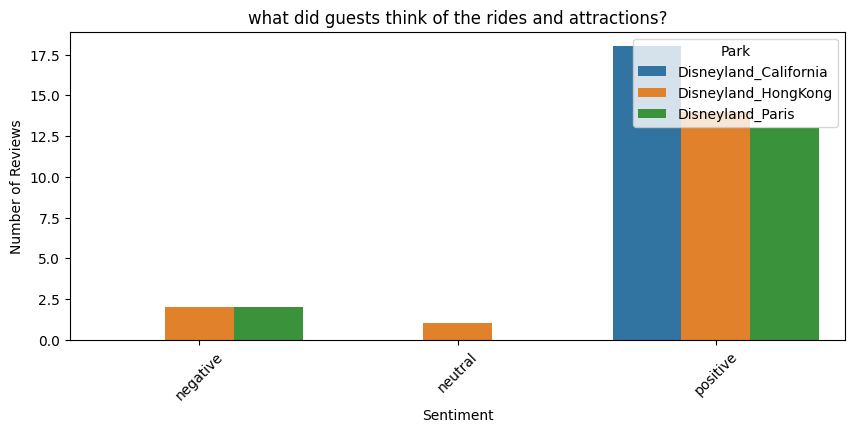

In [94]:
query = "what did guests think of the rides and attractions?"
n=50
print('Top 3 matches:', search_and_extract_results(query,n)[:3]["Review_Text"])
plot_sentiment(query,n)

We can see the guests are extremely satisfied with the rides and attractions at all 3 resorts with Disneyland California coming out on top with no negative reviews related to rides and attractions.

### Guest satisfaction with food

Top 3 matches: 0    Visited the Park today   20 4   and can conclude that they simply let too many people in. Already at opening, queues at the attractions where 1 hour plus. At midday   the so called fast track was ...
1                                                                                             I wish they had better food restaurant choices, but the attractions make up for this deficit so it's all good.
2    We found this park to provide family friendly fun with a variety of shows and rides. We pre paid our tickets to save time which was a benefit and were glad we paid extra for the park hopper ticket...
Name: Review_Text, dtype: object


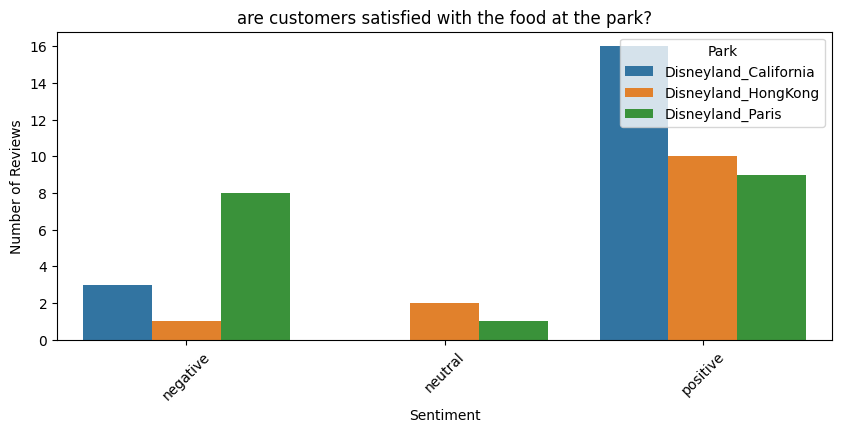

In [98]:
query = "are customers satisfied with the food at the park?"
n=50
print('Top 3 matches:', search_and_extract_results(query,n)[:3]["Review_Text"])
plot_sentiment(query,n)

Things don't fare as well when it comes to satisfaction on the food at each resort, we see a lot more negative food related reviews especially for Disneyland Paris.

### Guest satisfaction with staff

Top 3 matches: 0    This was very disappointing on this visit, three times in last four years. A number of the attraction s being closed and queues being very large for some of the rides. There appeared to be. A shor...
1    First time at Disneyland Paris and had the most magical time. Loved that there were bigger rides for thrill seekers. Wait times not always accurate which was annoying as you lined up for a 20 minu...
2    Took a five year old and a two year old. Could not fault anything other than a hire pram being pinched, which was quickly replaced.  Staff amazing. If you can stay at one of the hotels, do so.  Ma...
Name: Review_Text, dtype: object


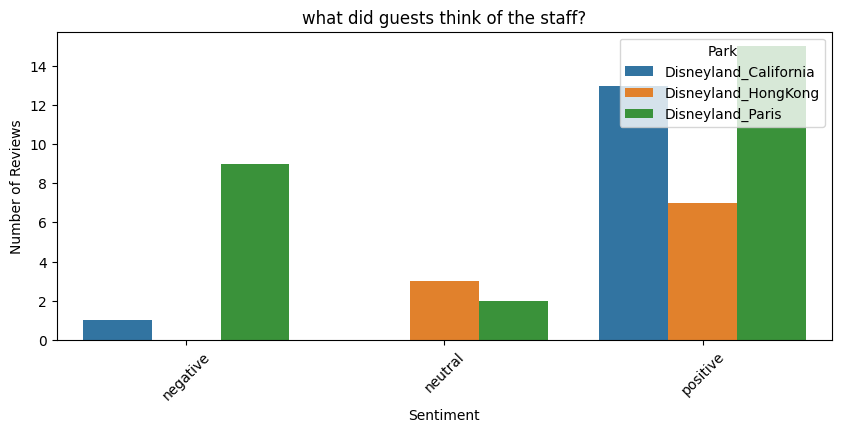

In [109]:
query = "what did guests think of the staff?"
n=50
print('Top 3 matches:', search_and_extract_results(query,n)[:3]["Review_Text"])
plot_sentiment(query,n)

Similarly for satisfaction with the staff - the most amount of negative reviews are coming for Disneyland Paris with less for California and none for Hong Kong.

Of course we took a subset of data - just 150 of the 42,000 reviews so to get more meaningful insights it would be a good idea to run the analysis on the full dataset.